# Pair Trading Implementation

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
import pyautogui
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
#import Loader

In [2]:
import sys
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')

In [3]:
#from DataModeling import Loader_v2
from Loader_v2 import Loader
ldr = Loader()
conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')

In [4]:
def whenNtimes(r, n):
    t=1
    c=0
    while (n>=t):
        t *= (1+r)
        c += 1
    return c

In [5]:
def Filtering(dt, sc_codes, by=None):
    conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    """Basic Filtering"""
    # 자본 총계가 하위 50% or 연평균(?합?) 거래량이 하위 30%
    tdf = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='자본총계'",conn)
    equity_half = tdf['value'].quantile(q=0.1, interpolation='nearest')
    equity_half_ls = set(tdf[lambda x : x['value']<=equity_half].code.values)
    code_ls = list(set(code_ls) - equity_half_ls)

    df = pd.read_sql(f"select code, date, volume from daily_price where date between '{dt[:4]+'-01-01'}' and '{dt[:4]+'-12-31'}'",conn)
    volume_30 = df.groupby(by='code').mean()['volume'].quantile(q=0.1,interpolation='nearest')
    volume_30_ls = set(df[lambda x : x['volume']<=volume_30].code.values)
    code_ls = list(set(code_ls) - volume_30_ls)

    if by == None :
        return list(set(code_ls).intersection(sc_codes))
    else :
        for e in by :
            if e == 'PBR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PBR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
            elif e == 'PCR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PCR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업활동현금흐름'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_cfc = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_cfc.append(cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_cfc))
            elif e == 'POR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='POR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업이익'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_profit = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_profit.append(Cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_profit))
            else :
                raise ValueError("Can't be !!")
        return list(set(code_ls).intersection(sc_codes))

In [6]:
def Filtering_v2(dt, sc_codes, by=None):
    conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    """Basic Filtering"""
    # 자본 총계가 하위 50% or 연평균(?합?) 거래량이 하위 30%
    tdf = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='자본총계'",conn)
    equity_half = tdf['value'].quantile(q=0.2, interpolation='nearest')
    equity_half_ls = set(tdf[lambda x : x['value']<=equity_half].code.values)
    code_ls = list(set(code_ls) - equity_half_ls)

    df = pd.read_sql(f"select code, date, volume from daily_price where date between '{dt[:4]+'-01-01'}' and '{dt[:4]+'-12-31'}'",conn)
    volume_30 = df.groupby(by='code').mean()['volume'].quantile(q=0.2,interpolation='nearest')
    volume_30_ls = set(df[lambda x : x['volume']<=volume_30].code.values)
    code_ls = list(set(code_ls) - volume_30_ls)
    
    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='당기순이익' and value>=0",conn)
    code_ls = list(set(code_ls).intersection(set(df.code.values)))

    if by == None :
        return list(set(code_ls).intersection(sc_codes))
    else :
        for e in by :
            if e == 'PBR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PBR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
            elif e == 'PCR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PCR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업활동현금흐름'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_cfc = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_cfc.append(cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_cfc))
            elif e == 'POR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='POR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업이익'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_profit = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_profit.append(Cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_profit))
            else :
                raise ValueError("Can't be !!")
        return list(set(code_ls).intersection(sc_codes))

In [7]:
def Correlation_v3(log_pr, cutoff=0.05):
    rst = pd.DataFrame(columns=['corr','A','B'])
    codes = list(log_pr.columns)
    for i in range(len(codes)):
        for j in range(len(codes)):
            if i<j:
                corr, pvalue = stats.pearsonr(log_pr[codes[i]], log_pr[codes[j]])
                if pvalue <= cutoff and corr >= 0:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = corr
                    tmp.loc[0,'A'] = codes[i]
                    tmp.loc[0,'B'] = codes[j]
                    rst = pd.concat([rst, tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

In [8]:
def PartialCorrelation_v2(df, x,y,kospi):
    x = np.array(df[x]).reshape(-1,1)
    y = np.array(df[y]).reshape(-1,1)
    start = df.index[0]
    end = df.index[-1]
    #print(start, end)
    ksp = kospi[(kospi.index>=start)&(kospi.index<=end)]
    #ksp = kospi
    z = np.array(ksp['close']).reshape(-1,1)

    # Remove Market Factor by KOSPI
    reg1 = LinearRegression().fit(z, x)
    x_res = x - reg1.predict(z)
    reg2 = LinearRegression().fit(z, y)
    y_res = y - reg2.predict(z)

    corr, pvalue = stats.pearsonr(x_res.reshape(-1,), y_res.reshape(-1,))
    
    return corr, pvalue

In [9]:
def ExpectedEarning(a, b, eta, pr, enter=1):
    pr = pr[[a,b]]
    log_pr = np.log(pr)
    spread = log_pr[a] - log_pr[b] * eta
    spread_df = pd.DataFrame(spread, columns=['spread'])
    invade = spread.mean() - enter*spread.std()
    invade_idx = list(spread_df[lambda x : x['spread'] <= invade].index)
    equib = spread.mean()
    equib_idx = list(spread_df[lambda x : x['spread'] >= equib].index)
    
    trade_idx = []
    flagInvade = True
    for idx, row in spread_df.iterrows():
        if flagInvade and row.spread <= invade :
            trade_idx.append(idx)
            flagInvade = False
        elif not flagInvade and row.spread >= equib :
            trade_idx.append(idx)
            flagInvade = True
    
    earnings = spread_df[spread_df.index.isin(trade_idx)].diff(1)
    earnings = earnings.iloc[[i*2+1 for i in range(0,int(len(earnings)/2))],:]
    trade_num = len(earnings)
    #earnings = earnings.sum()[0]
    earnings = np.exp(((np.log(earnings+1)).cumsum().iloc[-1,0]) / trade_num)
            
    return earnings, trade_num

In [10]:
def SameSector(rst, comp):
    yes_idx = []
    for idx, row in rst.iterrows():
        try :
            a = row.A
            b = row.B
            a_sc = comp[comp.code==a]['sector'].values[0]
            b_sc = comp[comp.code==b]['sector'].values[0]
            if a_sc == b_sc :
                yes_idx.append(idx)
        except :
            pass
    return rst[rst.index.isin(yes_idx)]

In [11]:
def DiffCorrelation(rst, log_pr, cutoff=0.05):
    df = rst.copy()
    df.reset_index(drop=True, inplace=True)
    diff_corr = []
    for idx, row in df.iterrows():
        a = row.A
        b = row.B
        a_v = log_pr[a].diff(1).dropna(axis=0)
        b_v = log_pr[b].diff(1).dropna(axis=0)
        r, pv = stats.pearsonr(a_v, b_v)
        if pv <= cutoff and r >=0 :
            diff_corr.append(r)
        else :
            diff_corr.append(-999.9)
    df['dcorr'] = diff_corr
    return df[lambda x : x['dcorr']!=-999.9]

In [12]:
def AddVolMcp(df):
    mcp = pd.read_csv("./FullCache/marcap/marcap-2021-01-14.csv")
    f = lambda x : int(x.replace(',',''))
    mcp['거래량'] = mcp['거래량'].map(f)
    mean_vol = []
    mean_mcp = []
    for idx, row in df.iterrows():
        a = row.A
        b = row.B
        tmp = mcp[(mcp.종목코드.isin([a,b]))][['거래량','시가총액비중(%)']].mean()
        mean_vol.append(tmp[0])
        mean_mcp.append(tmp[1])
    df['AvgVol'] = mean_vol
    df['AvgMcpRate'] = mean_mcp
    return df

In [13]:
def ExpectedEarning_v2(a, b, eta, pr, enter=1, position='A'):
    with open("TradingDates.pickle", "rb") as fr:
        trading_dates = pickle.load(fr)
    pr = pr[[a,b]]
    log_pr = np.log(pr)
    spread = log_pr[a] - log_pr[b] * eta
    spread_df = pd.DataFrame(spread, columns=['spread'])
    if position=='A':
        invade = spread.mean() - enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] <= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] >= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread <= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread >= equib :
                trade_idx.append(idx)
                flagInvade = True
                
    elif position=='B':
        invade = spread.mean() + enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] >= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] <= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread >= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread <= equib :
                trade_idx.append(idx)
                flagInvade = True
    else :
        raise ValueError("Can't Be.")

    
    earnings = spread_df[spread_df.index.isin(trade_idx)].diff(1)
    earnings = earnings.iloc[[i*2+1 for i in range(0,int(len(earnings)/2))],:]
    earning_dates = list(earnings.index)
    max_term = 0
    for idx in range(len(earning_dates)):
        if idx != len(earning_dates)-1 :
            term = trading_dates.index(earning_dates[idx+1]) - trading_dates.index(earning_dates[idx])
            if max_term <= term:
                max_term = term
    
    trade_num = len(earnings)
    if position=='A':
        earnings = np.exp(((np.log(earnings+1)).cumsum().iloc[-1,0]) / trade_num)
    elif position=='B':
        earnings = np.exp(((np.log((earnings*(-1))+1)).cumsum().iloc[-1,0]) / trade_num)
    
    return earnings, trade_num, max_term

In [14]:
def BestPairSelector(pair_df,comp):
    tmp = pair_df.copy()
    rank_dict = {}
    for idx in list(tmp.index):
        rank_dict[idx] = 0
    tmp['abs_cointeg'] = abs(tmp['cointeg']-1)
    tmp['best_funda'] = tmp['A_Funda(+)'] + tmp['B_Funda(+)']
    sector_ls = []
    for idx, row in tmp.iterrows():
        a = row.A
        b = row.B
        if comp[lambda x : x['code']==a].sector.values[0] == comp[lambda x : x['code']==b].sector.values[0]:
            sector_ls.append('Y')
        else :
            sector_ls.append('N')
        #sector_ls.append(comp[lambda x : x['code']==a].sector.values[0] + '-' + comp[lambda x : x['code']==b].sector.values[0])
    tmp['sector'] = sector_ls
    
    T = len(pair_df)
    """ CoInteg Coeff """
    for ith, idx in enumerate(list(tmp.sort_values(by=['abs_cointeg']).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['corr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['pcorr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['dcorr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['best_funda'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['AvgVol'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['risk'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['A_trade#'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['B_trade#'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['A_maxterm']).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['B_maxterm']).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['A_earnings(%)'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['B_earnings(%)'],ascending=False).index)):
        rank_dict[idx] += T - ith
    tmp['SCORE'] = tmp.index.map(rank_dict)
    tmp = tmp.drop(['best_funda','abs_cointeg'],axis=1)
    tmp = tmp.sort_values(by=['SCORE'],ascending=False).reset_index(drop=True)
    return tmp

In [15]:
def TradeVisual(A, B, eta, start, end, pr, enter=1):
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    print("{} & {}".format(ldr.FindNameByCode(A),ldr.FindNameByCode(B)))
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')

    ax1.hlines(spread.mean(),0,len(spread_full),colors='r',linewidth=3)
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='g',linewidth=3)

    ax2.plot(spread_full.reset_index().index, (aa_full - aa_full.mean())/aa_full.std(),label='A')
    ax2.plot(spread_full.reset_index().index, (bb_full - bb_full.mean())/bb_full.std(), label='B')
    ax2.vlines(len(spread),-4,4,colors='g',linewidth=3)
    ax2.legend(loc='upper left')
    plt.show()
    return True

In [16]:
def SpreadDiverge(a, b, eta, check_start, train_pr, test_pr, enter=2, ndays=25):
    train_pr = train_pr[[a,b]]
    log_pr = np.log(train_pr)
    spread = log_pr[a] - log_pr[b] * eta
    mu = spread.mean()
    sigma = spread.std()
    test_pr = test_pr[test_pr.index>=check_start]
    test_pr = test_pr[[a,b]]
    test_log_pr = np.log(test_pr)
    test_spread = test_log_pr[a] - test_log_pr[b] * eta
    
    spread_df = pd.DataFrame(test_spread, columns=['spread'])
    UpCut = mu + enter * sigma
    DownCut = mu - enter * sigma
    index_ls = list(spread_df.index)
    Down_ls = []
    Up_ls = []
    for idx, row in spread_df.iterrows():
        if row.spread < DownCut :
            Down_ls.append(-1)
        else :
            Down_ls.append(+1)
            
        if row.spread > UpCut :
            Up_ls.append(-1)
        else :
            Up_ls.append(+1)
    sub = spread_df.copy()
    sub['Down'] = Down_ls
    sub['Up'] = Up_ls
    max_term = 0
    new_idx = 0
    for idx in index_ls:
        if sub.loc[idx,'Down'] == -1:
            tmp = sub[sub.index>idx][lambda x : x['Down']==+1]
            if len(tmp)!= 0:
                new_idx = tmp.index[0]
                term = index_ls.index(new_idx) - index_ls.index(idx)
                if term > max_term :
                    max_term = term
            else :
                new_idx = index_ls[-1]
                term = index_ls.index(new_idx) - index_ls.index(idx) + 1
                if term > max_term :
                    max_term = term
                break
    if max_term >= ndays :
        #print("Down Divergence")
        return True, max_term
    
    umax_term = 0
    new_idx = 0
    for idx in index_ls:
        if sub.loc[idx,'Up'] == -1:
            tmp = sub[sub.index>idx][lambda x : x['Up']==+1]
            if len(tmp)!= 0:
                new_idx = tmp.index[0]
                term = index_ls.index(new_idx) - index_ls.index(idx)
                if term > umax_term :
                    umax_term = term
            else :
                new_idx = index_ls[-1]
                term = index_ls.index(new_idx) - index_ls.index(idx) + 1
                if term > umax_term :
                    umax_term = term
                break
    if umax_term >= ndays :
        #print("Up Divergence")
        return True, umax_term
    if max_term < umax_term :
        max_term = umax_term
    #print("No Divergence")
    return False, max_term

In [17]:
def FundaMatch(dt, byFunda='all'):
    conn = pymysql.connect(host='localhost',user='root', password='tlqkfdk2',db='INVESTAR',charset='utf8')
    company = pd.read_sql("select * from company_info", conn)
    codes = list(company.code.values)
    if dt == '2019-12':
        best_funda = pd.read_hdf("FullCache/BestFundaPattern.h5")
    else :
        best_funda = FundaPattern_v2(dt)
    dt_idx = {'2016-12':0,'2017-12':1,'2018-12':2,'2019-12':3}
    sectors = list(set(best_funda.index))
    company = company[company.sector.isin(sectors)]
    funda_codes = pd.read_pickle("FundaPatternCodes_v2.pickle")[dt_idx[dt]]
    #codes = list(company.code.values)
    bestfunda_dict = {}
    for sc in sectors :
        sub_ls = []
        for fd in ['PBR','PCR','PER','POR','PSR','EPS','BPS','ROE','ROA','시가총액'] : 
            sub = best_funda[(best_funda.index==sc)&(best_funda.Funda==fd)]
            sub_ls.append(sub.loc[sc,'Funda'] + '-' + sub.loc[sc,'BestQuantile'])
        bestfunda_dict[sc] = sub_ls
    agg_codes = []
    for key in bestfunda_dict.keys():
        for bfd in bestfunda_dict[key]:
            if byFunda == 'all':
                agg_codes += funda_codes[(funda_codes.index==key)&(funda_codes['FD-Q']==bfd)].loc[key,'Codes']
            elif type(byFunda)==list and len(byFunda)!=0:
                if bfd[:3] in byFunda :
                    agg_codes += funda_codes[(funda_codes.index==key)&(funda_codes['FD-Q']==bfd)].loc[key,'Codes']
            else :
                raise ValueError("byFunda Insertion Error")
    score_dict = {}
    for cd in codes :
        if cd in agg_codes:
            score_dict[cd] = agg_codes.count(cd)
        else :
            score_dict[cd] = 0
    return score_dict

In [18]:
def FundaPattern_v2(end_dt = '2019-12'):
    dates = ['2016-12','2017-12','2018-12','2019-12']
    dts = []
    for dt in dates:
        if dt <= end_dt:
            dts.append(dt)
    all_funda = pd.DataFrame()
    for dt in dts :
        all_funda = pd.concat([all_funda,Funda(dt)])
    all_sector = list(set(all_funda.index))
    fundas = list(set(all_funda.Funda.values))
    rst = pd.DataFrame(columns=['Funda','BestQuantile'])
    for sc in all_sector :
        for fd in fundas :
            b_q = all_funda[(all_funda.index==sc)&(all_funda.Funda==fd)]['Quantile'].value_counts().index[0]
            tmp = pd.DataFrame(index=[sc], columns=['Funda','BestQuantile'])
            tmp.loc[sc,'Funda'] = fd
            tmp.loc[sc,'BestQuantile'] = b_q
            rst = pd.concat([rst,tmp])
    return rst

In [19]:
def PairTrading_v10(pr, start, end, real_start, real_end, byFunda='all', up_cut=0.2, down_cut=-0.15, cutoff=0.05, fltr=True, enter=1, ndays=22):
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    real_pr = pr[(pr.index>=real_start)&(pr.index<=real_end)]
    real_pr.dropna(axis=1,how='any')
    log_real_pr = np.log(real_pr)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ * Filtering """ # Funda 정보가 부족하다고 제외할 수 있는 것일까..
#     best_funda = pd.read_hdf("FullCache/BestFundaPattern.h5")
#     sectors = list(set(best_funda.index))
#     conn = pymysql.connect(host='localhost',user='root',
#                                    password='tlqkfdk2',db='INVESTAR',charset='utf8')
#     company = pd.read_sql("select * from company_info",conn)
#     sector_codes = list(company[company.sector.isin(sectors)].code.values)
#     most_sectors = list(set(log_pr.columns).intersection(set(sector_codes)))
#     pr = pr[most_sectors]
#     log_pr = log_pr[most_sectors]
#     print("Filtered by Most Funda Sectors -> now : {}".format(len(pr.columns)))
    
    if fltr :
        dt = str(int(start[:4])-1)+'-12'
        fltrd_ls = Filtering_v2(dt, list(log_pr.columns), by=['PBR'])
        log_pr = log_pr[fltrd_ls]
        pr = pr[fltrd_ls]
        print("Filtered by NetIncome & PBR & Equity & Volume -> now : {}".format(len(fltrd_ls)))
    
    """ * Stop & Loss Cut"""
    pr_rt = pr.pct_change()
    out_ls = []
    for cd in pr_rt.columns:
        if len(pr_rt[lambda x : x[cd] < down_cut]) >= 2 : # 1번이라도 나오면 없애야 하나?
            out_ls.append(cd)
    log_pr.drop(out_ls, axis=1, inplace=True)
    pr.drop(out_ls, axis=1, inplace=True)
    print("Excluding stop-loss condition with {} : -> now : {}".format(down_cut, len(pr.columns)))
    
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_close.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(1,41)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls
    
#     A_up = []
#     B_up = []
#     for idx, row in pairs.iterrows():
#         a = row.A
#         b = row.B
#         A_up.append(len(pr_rt[lambda x : x[a]>=up_cut]))
#         B_up.append(len(pr_rt[lambda x : x[b]>=up_cut]))
#     pairs['A_Over{}%'.format(int(up_cut*100))] = A_up
#     pairs['B_Over{}%'.format(int(up_cut*100))] = B_up
    
    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    
    
    """ 13) Checking whole results on TEST Period """
    """ CoInteg + Stationary + Normality + Corr """
    survive_ls = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        eta = row.cointeg
        a_val = log_real_pr[a]
        b_val = log_real_pr[b]
        real_spread = a_val - b_val * eta
        if coint(a_val, b_val)[1] <= cutoff:
            if adfuller(real_spread)[1] <= cutoff:
                if stats.shapiro(real_spread)[1] >= cutoff :
                    survive_ls.append(idx)
                    #tmp = stats.pearsonr(a_val, b_val)
                    #if tmp[0]>=0 and tmp[1] <= cutoff:
                    #    survive_ls.append(idx)
    
    """ 14) Best Funda Quantile Pattern Check """
    FundaScore_A = []
    FundaScore_B = []
    if int(real_end[4:6])>=4:
        dt = str(int(real_end[:4])-1)+'-12'
        score_dict = FundaMatch(dt, byFunda=byFunda)
        for idx, row in pairs.iterrows():
            a = row.A
            b = row.B
            FundaScore_A.append(score_dict[a])
            FundaScore_B.append(score_dict[b])
    else :
        dt = str(int(real_end[:4])-2)+'-12'
        score_dict = FundaMatch(dt, byFunda=byFunda)
        for idx, row in pairs.iterrows():
            a = row.A
            b = row.B
            FundaScore_A.append(score_dict[a])
            FundaScore_B.append(score_dict[b])
    pairs['A_Funda(+)'] = FundaScore_A
    pairs['B_Funda(+)'] = FundaScore_B
    
    """ 15) Spread Divergence Check """
    divcheck_idx = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        coint_coeff = row.cointeg
        if SpreadDiverge(a, b, coint_coeff, end, pr, real_pr, enter=2, ndays=ndays)[0] == False :
            divcheck_idx.append(idx)
    pairs = pairs[pairs.index.isin(divcheck_idx)]
    print("Validation w.r.t Spread Divergence : {} survived.".format(len(divcheck_idx)))
    
        
    return pairs, pairs[pairs.index.isin(survive_ls)]

In [20]:
def PriceCompare(rst, pr, diff=10000, min_pr=8000, max_pr=150000):
    valid_idx = []
    for idx, row in rst.iterrows():
        a = row.A
        b = row.B
        a_pr = pr[a].mean()
        b_pr = pr[b].mean()
        if a_pr >= min_pr and b_pr >= min_pr and a_pr <= max_pr and b_pr <= max_pr:
            if abs(a_pr - b_pr) <= diff:
                valid_idx.append(idx)
    return rst[rst.index.isin(valid_idx)]

In [21]:
def MedianFundaPatternFull(pr):
    comp = pd.read_sql("select * from company_info",conn)
    sectors = list(comp['sector'].value_counts().index)
    fundas = ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']
    rst = pd.DataFrame()
    for dt in ['2016-12','2017-12','2018-12','2019-12']:
        start = str(int(dt[:4])+1)+'-04-01'
        end = str(int(dt[:4])+2)+'-03-31'
        sub_pr = pr[(pr.index>=start)&(pr.index<=end)]
        total = pd.DataFrame(index=sectors,columns=fundas)
        for sc in sectors :
            sc_ls = list(comp[lambda x : x['sector']==sc].code.values)
            for fd in fundas :
                try :
                    tmp_fd = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='{fd}' and code in {tuple(sc_ls)}",conn)
                    median = tmp_fd.describe().loc['50%','value']
                    low_ls = list(tmp_fd[lambda x : x['value']<=median].code.values)
                    high_ls = list(tmp_fd[lambda x : x['value']>median].code.values)
                    low_er = np.log(sub_pr[low_ls].pct_change()+1).cumsum().iloc[-1].mean()
                    high_er = np.log(sub_pr[high_ls].pct_change()+1).cumsum().iloc[-1].mean()
                    if low_er >= high_er:
                        total.loc[sc,fd] = 'L'
                    else :
                        total.loc[sc,fd] = 'H'
                except :
                    pass
        rst = pd.concat([rst,total])
    final = pd.DataFrame(index=sectors, columns=fundas)
    for sc in sectors :
        for fd in fundas :
            if len(rst.loc[sc][fd].value_counts())==1:
                final.loc[sc,fd] = rst.loc[sc][fd].values[0]
    return final

In [22]:
def MedianFundaTestFull(pr, param=True, cutoff=0.05):
    comp = pd.read_sql("select * from company_info",conn)
    sectors = list(comp['sector'].value_counts().index)
    fundas = ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']
    rst = pd.DataFrame()
    for dt in ['2016-12','2017-12','2018-12','2019-12']:
        start = str(int(dt[:4])+1)+'-04-01'
        end = str(int(dt[:4])+2)+'-03-31'
        sub_pr = pr[(pr.index>=start)&(pr.index<=end)]
        total = pd.DataFrame(index=sectors,columns=fundas)
        for sc in sectors :
            sc_ls = list(comp[lambda x : x['sector']==sc].code.values)
            for fd in fundas :
                try :
                    tmp_fd = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='{fd}' and code in {tuple(sc_ls)}",conn)
                    median = tmp_fd.describe().loc['50%','value']
                    low_ls = list(tmp_fd[lambda x : x['value']<=median].code.values)
                    high_ls = list(tmp_fd[lambda x : x['value']>median].code.values)
                    low_array = np.log(sub_pr[low_ls].pct_change()+1).cumsum().iloc[-1]
                    high_array = np.log(sub_pr[high_ls].pct_change()+1).cumsum().iloc[-1]
                    if param :
                        if stats.ttest_ind(low_array, high_array,  equal_var=False)[1] <= cutoff:
                            pass
                        else :
                            continue
                    else :
                        if stats.mannwhitneyu(low_array, high_array)[1] <= cutoff:
                            pass
                        else :
                            continue
                    low_er = low_array.mean()
                    high_er = high_array.mean()
                    if low_er >= high_er:
                        total.loc[sc,fd] = 'L'
                    else :
                        total.loc[sc,fd] = 'H'
                except :
                    pass
        rst = pd.concat([rst,total])
    
    return rst

In [23]:
def BisectFunda(dt,pr,param=True,cutoff=0.05):
    comp = pd.read_sql("select * from company_info",conn)
    sectors = list(comp['sector'].value_counts().index)
    fundas = ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']
    total = pd.DataFrame(index=sectors,columns=fundas)
    for sc in sectors :
        sc_ls = list(comp[lambda x : x['sector']==sc].code.values)
        #tmp_pr = pr[sc_ls]
        for fd in fundas :
            try :
                tmp_fd = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='{fd}' and code in {tuple(sc_ls)}",conn)
                median = tmp_fd.describe().loc['50%','value']
                low_ls = list(tmp_fd[lambda x : x['value']<=median].code.values)
                high_ls = list(tmp_fd[lambda x : x['value']>median].code.values)
                low_array = np.log(pr[low_ls].pct_change()+1).cumsum().iloc[-1]
                high_array = np.log(pr[high_ls].pct_change()+1).cumsum().iloc[-1]
                if param :
                    if stats.ttest_ind(low_array, high_array,  equal_var=False)[1] <= cutoff:
                        pass
                    else :
                        continue
                else :
                    if stats.mannwhitneyu(low_array, high_array)[1] <= cutoff:
                        pass
                    else :
                        continue
                low_er = low_array.mean()
                high_er = high_array.mean()
                if low_er >= high_er:
                    total.loc[sc,fd] = 'L'
                else :
                    total.loc[sc,fd] = 'H'
            except :
                pass
    return total

In [24]:
def BisectFunda(dt,pr):
    comp = pd.read_sql("select * from company_info",conn)
    sectors = list(comp['sector'].value_counts().index)
    fundas = ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']
    total = pd.DataFrame(index=sectors,columns=fundas)
    for sc in sectors :
        sc_ls = list(comp[lambda x : x['sector']==sc].code.values)
        #tmp_pr = pr[sc_ls]
        for fd in fundas :
            try :
                tmp_fd = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='{fd}' and code in {tuple(sc_ls)}",conn)
                median = tmp_fd.describe().loc['50%','value']
                low_ls = list(tmp_fd[lambda x : x['value']<=median].code.values)
                high_ls = list(tmp_fd[lambda x : x['value']>median].code.values)
                low_er = np.log(pr[low_ls].pct_change()+1).cumsum().iloc[-1].mean()
                high_er = np.log(pr[high_ls].pct_change()+1).cumsum().iloc[-1].mean()
                if low_er >= high_er:
                    total.loc[sc,fd] = 'L'
                else :
                    total.loc[sc,fd] = 'H'
            except :
                print(sc,fd)
                #raise ValueError('z')
    return total

In [25]:
def UniverseFilter(dt):
    conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    start_year = str(1+int(dt[:4]))
    start_date = start_year + '-04-01'
    end_year = str(2+int(dt[:4]))
    end_date = end_year + '03-31'
    """ 1) Volume over MEDIAN """
    try :
        pr = pd.read_hdf("./FullCache/Price/price_{}.h5".format(end_year))
    except :
        pr = pd.read_hdf("./FullCache/Price/price_{}.h5".format(start_year))
    vol_last60 = pr[pr.DATE.isin(sorted(list(set(pr.DATE.values)))[-60:])].groupby('CODE').mean()
    vol_median = vol_last60[['volume']].describe().loc['50%','volume']
    vol_ls = list(vol_last60[lambda x : x['volume']>=vol_median].index)
    
    """ 2) MarketCap over MEDIAN """
    mcp = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='시가총액'",conn)
    mcp_median = mcp.describe().loc['50%','value']
    mcp_ls = list(mcp[lambda x : x['value']>=mcp_median].code.values)
    
    profit = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and type='Y' and itm='당기순이익'",conn)
    profit_ls = list(profit[lambda x : x['value']>0].code.values)
    pbr = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and type='Y' and itm='PBR' and code in {tuple(profit_ls)}",conn)
    pbr_ls = list(pbr[lambda x : x['value']>0].code.values)
    pcr = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and type='Y' and itm='PCR' and code in {tuple(pbr_ls)}",conn)
    pcr_ls = list(pcr[lambda x : x['value']>0].code.values)
    por = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and type='Y' and itm='POR' and code in {tuple(pcr_ls)}",conn)
    por_ls = list(por[lambda x : x['value']>0].code.values)
    
    set1 = set(set(vol_ls).union(set(mcp_ls)))
    set2 = set(por_ls)
    total_ls = list(set1.intersection(set2))
    print("Our Universe : {}".format(len(total_ls)))
    return total_ls

In [26]:
def BestPairSelector_v2(pair_df, comp):
    tmp = pair_df.copy()
    rank_dict = {}
    for idx in list(tmp.index):
        rank_dict[idx] = 0
    tmp['abs_cointeg'] = abs(tmp['cointeg']-1)
    #tmp['best_funda'] = tmp['A_Funda(+)'] + tmp['B_Funda(+)']
    sector_ls = []
    for idx, row in tmp.iterrows():
        a = row.A
        b = row.B
        if comp[lambda x : x['code']==a].sector.values[0] == comp[lambda x : x['code']==b].sector.values[0]:
            sector_ls.append('Y')
        else :
            sector_ls.append('N')
        #sector_ls.append(comp[lambda x : x['code']==a].sector.values[0] + '-' + comp[lambda x : x['code']==b].sector.values[0])
    tmp['sector'] = sector_ls
    
    T = len(pair_df)
    """ CoInteg Coeff """
    for ith, idx in enumerate(list(tmp.sort_values(by=['abs_cointeg']).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['corr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['pcorr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['dcorr'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['AvgVol'],ascending=False).index)):
        rank_dict[idx] += T - ith
    for ith, idx in enumerate(list(tmp.sort_values(by=['risk'],ascending=False).index)):
        rank_dict[idx] += T - ith
    tmp['SCORE'] = tmp.index.map(rank_dict)
    #tmp = tmp.drop(['best_funda','abs_cointeg'],axis=1)
    
    tmp = tmp.sort_values(by=['SCORE'],ascending=False).reset_index(drop=True)
    return tmp

### Steps

1) Correlation : log prices' correlation check (highest correlation pairs) <br>
2) Partial Correlation : Residuals whose KOSPI or ETF market factor are eliminated should be correlated. <br>
3) CoIntegration : First check their cointegration relationship. Second optimize best coefficient of cointegration w.r.t autocorrelation coeff and ADF-p-value. <br>
4) Coeff Estimation : With above coeff do estimation of coeff of spread values' cointegration or regression. <br>
5) Spread Estimation : Fit and estimate spread's values. (Like lnA - n*lnB)<br>
6) Trend : Check whether there exists trend in estimated spreads and remove those to get residuals that would be have stationarity. <br>
7) Normality : Spread's normality by Shapiro-Wilks test. <br>
8) Stationarity : Spread's stationarity by ADF test. <br>
9) Validation : For recent data. <br>
10) Invasion Timing : For real trading. <br>

* I'll set my trading period as 1-year ('04-01'~'03-31') for announcement of fundamental report.

---

### Total Func

In [372]:
ldr.FindNameByCode('161390'),ldr.FindNameByCode('000240')

('한국타이어앤테크놀로지', '한국테크놀로지그룹')

In [426]:
ldr.FindNameByCode('003530'),ldr.FindNameByCode('086790')

('한화투자증권', '하나금융지주')

---

### Plot -> Func로 만들자

### 리스트
- 케이티앤지, 기업은행 <br>
- 삼성물산, 삼성전기 <br>
- 기아자동차, 한국타이어테크놀로지 <br>

* 씹... daily_price adj가 아니라 price.h5로 해야겠네.. 저걸 오 ㅐ했지?

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ <br>
https://skyeong.net/282

---

#### 깨달음

* csv로 dataframe을 저장하면 index는 따로 column으로 저장해야 한다.<br>
* 만약 index를 살리고 싶으면 hdf로 저장해야 한다..

##### 1) Correlation

In [208]:
def Correlation(log_pr):
    log_pr_corr = log_pr.corr()
    rst = pd.DataFrame(columns=['corr','A','B'])
    for i in range(len(log_pr_corr)):
        for j in range(len(log_pr_corr)):
            if i<j :
                if log_pr_corr.iloc[i,j]!= 1 and log_pr_corr.iloc[i,j]!= -1:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = log_pr_corr.iloc[i,j]
                    tmp.loc[0,'A'] = log_pr_corr.index[i]
                    tmp.loc[0,'B'] = log_pr_corr.index[j]
                    rst = pd.concat([rst,tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

In [14]:
def Correlation_v2(log_pr, cutoff=0.05):
    rst = pd.DataFrame(columns=['corr','A','B'])
    codes = list(log_pr.columns)
    for i in range(len(codes)):
        for j in range(len(codes)):
            if i<j:
                corr, pvalue = stats.pearsonr(log_pr[codes[i]], log_pr[codes[j]])
                if pvalue <= cutoff:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = corr
                    tmp.loc[0,'A'] = codes[i]
                    tmp.loc[0,'B'] = codes[j]
                    rst = pd.concat([rst, tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

In [190]:
def Correlation_v3(log_pr, cutoff=0.05):
    rst = pd.DataFrame(columns=['corr','A','B'])
    codes = list(log_pr.columns)
    for i in range(len(codes)):
        for j in range(len(codes)):
            if i<j:
                corr, pvalue = stats.pearsonr(log_pr[codes[i]], log_pr[codes[j]])
                if pvalue <= cutoff and corr >= 0:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = corr
                    tmp.loc[0,'A'] = codes[i]
                    tmp.loc[0,'B'] = codes[j]
                    rst = pd.concat([rst, tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

---

##### 2) Partial Correlation

In [52]:
def PartialCorrelation(df, x,y,kospi):
    x = np.array(df[x])
    y = np.array(df[y])
    start = df.index[0]
    end = df.index[-1]
    ksp = kospi[(kospi.index>=start)&(kospi.index<=end)]
    z = np.array(ksp['close'])
    cor_xy = np.corrcoef(x,y)[0,1]
    cor_xz = np.corrcoef(x,z)[0,1]
    cor_yz = np.corrcoef(y,z)[0,1]
    return (cor_xy - cor_xz * cor_yz) / (np.sqrt(1-cor_xz*cor_xz) * np.sqrt(1-cor_yz*cor_yz))

In [16]:
def PartialCorrelation_v2(df, x,y,kospi):
    x = np.array(df[x]).reshape(-1,1)
    y = np.array(df[y]).reshape(-1,1)
    start = df.index[0]
    end = df.index[-1]
    ksp = kospi[(kospi.index>=start)&(kospi.index<=end)]
    z = np.array(ksp['close']).reshape(-1,1)

    # Remove Market Factor by KOSPI
    reg1 = LinearRegression().fit(z, x)
    x_res = x - reg1.predict(z)
    reg2 = LinearRegression().fit(z, y)
    y_res = y - reg2.predict(z)

    corr, pvalue = stats.pearsonr(x_res.reshape(-1,), y_res.reshape(-1,))
    
    return corr, pvalue

##### 둘 다 같은 결과를 준다!

---

##### 3) CoIntegration

* B의 A에 대한 CoInteg Coeff = COV(A,B) / V(B)

In [ ]:
def stationarity_test(pr, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    non_stat = []
    yes_stat = []
    errs = []
    for cd in list(pr.columns):
        try :
            sub_df = pr[[cd]].dropna(axis=0)
            pvalue = adfuller(sub_df[cd])[1]
            if pvalue < cutoff:
                yes_stat.append(cd)
            else :
                non_stat.append(cd)
        except:
            errs.append(cd)
    return non_stat, yes_stat, errs

---

### Filtering Funda

In [581]:
len(set(pd.read_sql("select * from finance_info_copy where date='2020-02'",conn).code.values))

8

### ㅅㅂ 무슨 date가 2020-02지..

### 3/19일날 코로나 때문인지 경제 박살났었네 거의 모든 주식이

In [95]:
def PairTrading_v8(pr, start, end, real_start, real_end, up_cut=0.2, down_cut=-0.15, cutoff=0.05, fltr=True, enter=1):
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    real_pr = pr[(pr.index>=real_start)&(pr.index<=real_end)]
    real_pr.dropna(axis=1,how='any')
    log_real_pr = np.log(real_pr)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ * Filtering """
    best_funda = pd.read_hdf("FullCache/BestFundaPattern.h5")
    sectors = list(set(best_funda.index))
    conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
    company = pd.read_sql("select * from company_info",conn)
    sector_codes = list(company[company.sector.isin(sectors)].code.values)
    most_sectors = list(set(log_pr.columns).intersection(set(sector_codes)))
    pr = pr[most_sectors]
    log_pr = log_pr[most_sectors]
    print("Filtered by Most Funda Sectors -> now : {}".format(len(pr.columns)))
    
    if fltr :
        dt = str(int(start[:4])-1)+'-12'
        fltrd_ls = Filtering_v2(dt, list(log_pr.columns), by=['PBR'])
        log_pr = log_pr[fltrd_ls]
        pr = pr[fltrd_ls]
        print("Filtered by NetIncome & PBR & Equity & Volume -> now : {}".format(len(fltrd_ls)))
    
    """ * Stop & Loss Cut"""
    pr_rt = pr.pct_change()
    out_ls = []
    for cd in pr_rt.columns:
        if len(pr_rt[lambda x : x[cd] < down_cut]) >= 2 : # 1번이라도 나오면 없애야 하나?
            out_ls.append(cd)
    #survive_ls = list(set(pr.columns) - set(out_ls))
    log_pr.drop(out_ls, axis=1, inplace=True)
    pr.drop(out_ls, axis=1, inplace=True)
    print("Excluding stop-loss condition with {} : -> now : {}".format(down_cut, len(pr.columns)))
    
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_close.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(1,41)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
    #print(cointeg_rst)
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        return spread, log_pr[a], log_pr[b], coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls
    
#     A_up = []
#     B_up = []
#     for idx, row in pairs.iterrows():
#         a = row.A
#         b = row.B
#         A_up.append(len(pr_rt[lambda x : x[a]>=up_cut]))
#         B_up.append(len(pr_rt[lambda x : x[b]>=up_cut]))
#     pairs['A_Over{}%'.format(int(up_cut*100))] = A_up
#     pairs['B_Over{}%'.format(int(up_cut*100))] = B_up
    
    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    
    
    """ 13) Checking whole results on TEST Period """
    """ CoInteg + Stationary + Normality + Corr """
    survive_ls = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        eta = row.cointeg
        a_val = log_real_pr[a]
        b_val = log_real_pr[b]
        real_spread = a_val - b_val * eta
        if coint(a_val, b_val)[1] <= cutoff:
            if adfuller(real_spread)[1] <= cutoff:
                if stats.shapiro(real_spread)[1] >= cutoff :
                    survive_ls.append(idx)
                    #tmp = stats.pearsonr(a_val, b_val)
                    #if tmp[0]>=0 and tmp[1] <= cutoff:
                    #    survive_ls.append(idx)
                        

    return pairs, pairs[pairs.index.isin(survive_ls)]

In [16]:
def Funda(dt):
    start = str(int(dt[:4])+1)+'-04-01'
    end = str(int(dt[:4])+2)+'-03-31'
    pr1 = pd.read_hdf("FullCache/Price/lv2_price_{}.h5".format(str(int(dt[:4])+1)))
    pr2 = pd.read_hdf("FullCache/Price/lv2_price_{}.h5".format(str(int(dt[:4])+2)))
    pr = pd.concat([pr1,pr2])
    pr = pr.astype(float)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    funda_codes = pd.read_pickle("FundaPatternCodes_v2.pickle")
    dct = {}
    for i, e in enumerate(['2016-12','2017-12','2018-12','2019-12']):
        dct[e] = i
    funda_pattern = funda_codes[dct[dt]]
    all_sector = list(set(funda_pattern.index))
    all_funda = ['PBR','PCR','PER','POR','PSR','EPS','BPS','ROE','ROA','시가총액']
    total = pd.DataFrame(columns=['Funda','Quantile','MeanEarning'])
    for sc in all_sector:
        for fd in all_funda :
            max_earning = -99999
            best_quantile = '1'
            for q in ['1','2','3']:
                tmp_codes = funda_pattern[(funda_pattern.index==sc)&(funda_pattern['FD-Q']==fd+'-'+q)]['Codes'].values[0]
                tmp_earning = np.log(1+pr[tmp_codes].pct_change()).cumsum().iloc[-1,:].mean()
                if tmp_earning > max_earning:
                    max_earning = tmp_earning
                    best_quantile = q
            tmp_df = pd.DataFrame(index=[sc], columns=['Funda','Quantile','MeanEarning'])
            tmp_df.loc[sc,'Funda'] = fd
            tmp_df.loc[sc,'Quantile'] = best_quantile
            tmp_df.loc[sc,'MeanEarning'] = max_earning
            total = pd.concat([total, tmp_df])
    return total

In [290]:
%%time
ggg2 = Funda('2019-12')

Wall time: 3.17 s


In [286]:
def lv2_cache():
    #real_total = pd.DataFrame()
    years = [i for i in range(2010,2022)]
    for y in years :
        print(y)
        df = pd.read_hdf("FullCache/Price/price_{}.h5".format(str(y)))
        dates = sorted(list(set(df.DATE.values)))
        codes = list(set(df.CODE.values))
        total = pd.DataFrame()
        for cd in codes :
            tmp = df[lambda x : x['CODE']==cd].sort_values(by=['DATE'])[['DATE','adjprice']]
            tmp.index = [dt.strftime("%Y-%m-%d") for dt in tmp.DATE]
            tmp.drop(['DATE'],axis=1,inplace=True)
            tmp.columns = [cd]
            total = pd.concat([total,tmp],axis=1)
        total.to_hdf("FullCache/Price/lv2_price_{}.h5".format(str(y)),key='price')
        #real_total = pd.concat([real_total,total],axis=0)
    return True

In [249]:
def lv2(df_ls):
    real_total = pd.DataFrame()
    for df in df_ls :
        dates = sorted(list(set(df.DATE.values)))
        codes = list(set(df.CODE.values))
        total = pd.DataFrame()
        for cd in codes :
            tmp = df[lambda x : x['CODE']==cd].sort_values(by=['DATE'])[['DATE','adjprice']]
            tmp.index = [dt.strftime("%Y-%m-%d") for dt in tmp.DATE]
            tmp.drop(['DATE'],axis=1,inplace=True)
            tmp.columns = [cd]
            total = pd.concat([total,tmp],axis=1)
        real_total = pd.concat([real_total,total],axis=0)
    return real_total

##### 이건 cache로 저장해도 될 듯 한데?

* 포스코인터내셔널 파워로직스 <br>
* 대우건설 파워로직스..

In [35]:
f1 = pr[(pr.index>='2019-08-01')&(pr.index<='2020-07-31')]
f2 = pr[(pr.index>='2020-07-31')]

포스코인터내셔널 & 파워로직스


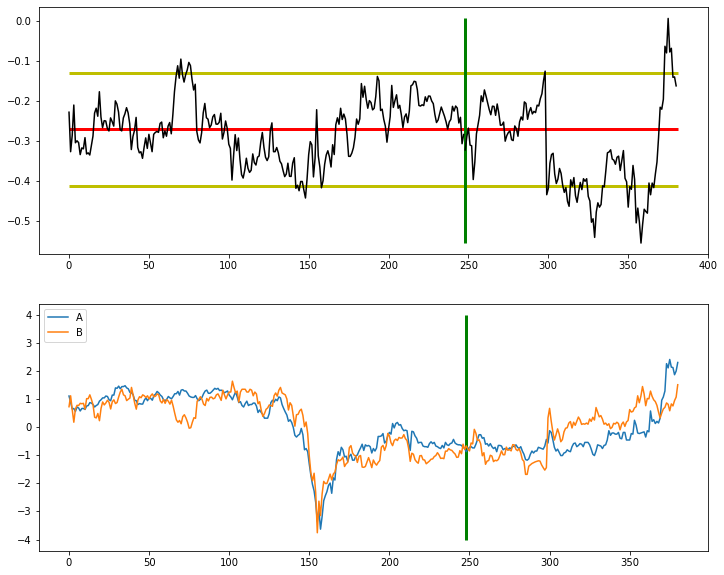

True

In [36]:
TradeVisual('047050','047310',1.1,'2019-08-01','2020-07-31',pr,2)

* 에스피지 현대모비스 : 에스피지가 현대에 납품하는 감속기 기업이네;;
* 삼성물산, 삼성전기가 진짜 pair-trade로 최고인듯..?

삼성물산 & 삼성전기


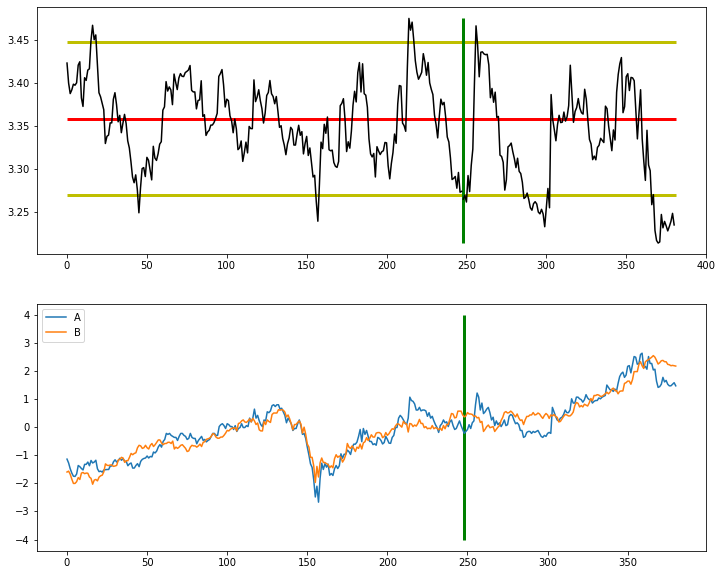

True

In [237]:
TradeVisual('028260','009150',0.7,'2019-08-01','2020-07-31',pr,2)

In [263]:
def TradeVisual(A, B, eta, start, end, pr, enter=1):
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    return (spread.mean(),spread.std())
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    
    print("{} & {}".format(ldr.FindNameByCode(A),ldr.FindNameByCode(B)))
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')

    ax1.hlines(spread.mean(),0,len(spread_full),colors='r',linewidth=3)
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='g',linewidth=3)

    ax2.plot(spread_full.reset_index().index, (aa_full - aa_full.mean())/aa_full.std(),label='A')
    ax2.plot(spread_full.reset_index().index, (bb_full - bb_full.mean())/bb_full.std(), label='B')
    ax2.vlines(len(spread),-4,4,colors='g',linewidth=3)
    ax2.legend(loc='upper left')
    plt.show()
    return True

In [17]:
def PairTrading_v10(pr, start, end, real_start, real_end, byFunda='all', up_cut=0.2, down_cut=-0.15, cutoff=0.05, fltr=True, enter=1, ndays=22):
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    real_pr = pr[(pr.index>=real_start)&(pr.index<=real_end)]
    real_pr.dropna(axis=1,how='any')
    log_real_pr = np.log(real_pr)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ * Filtering """ # Funda 정보가 부족하다고 제외할 수 있는 것일까..
#     best_funda = pd.read_hdf("FullCache/BestFundaPattern.h5")
#     sectors = list(set(best_funda.index))
#     conn = pymysql.connect(host='localhost',user='root',
#                                    password='tlqkfdk2',db='INVESTAR',charset='utf8')
#     company = pd.read_sql("select * from company_info",conn)
#     sector_codes = list(company[company.sector.isin(sectors)].code.values)
#     most_sectors = list(set(log_pr.columns).intersection(set(sector_codes)))
#     pr = pr[most_sectors]
#     log_pr = log_pr[most_sectors]
#     print("Filtered by Most Funda Sectors -> now : {}".format(len(pr.columns)))
    
    if fltr :
        dt = str(int(start[:4])-1)+'-12'
        fltrd_ls = Filtering_v2(dt, list(log_pr.columns), by=['PBR'])
        log_pr = log_pr[fltrd_ls]
        pr = pr[fltrd_ls]
        print("Filtered by NetIncome & PBR & Equity & Volume -> now : {}".format(len(fltrd_ls)))
    
    """ * Stop & Loss Cut"""
    pr_rt = pr.pct_change()
    out_ls = []
    for cd in pr_rt.columns:
        if len(pr_rt[lambda x : x[cd] < down_cut]) >= 2 : # 1번이라도 나오면 없애야 하나?
            out_ls.append(cd)
    log_pr.drop(out_ls, axis=1, inplace=True)
    pr.drop(out_ls, axis=1, inplace=True)
    print("Excluding stop-loss condition with {} : -> now : {}".format(down_cut, len(pr.columns)))
    
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_close.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(1,41)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls
    
#     A_up = []
#     B_up = []
#     for idx, row in pairs.iterrows():
#         a = row.A
#         b = row.B
#         A_up.append(len(pr_rt[lambda x : x[a]>=up_cut]))
#         B_up.append(len(pr_rt[lambda x : x[b]>=up_cut]))
#     pairs['A_Over{}%'.format(int(up_cut*100))] = A_up
#     pairs['B_Over{}%'.format(int(up_cut*100))] = B_up
    
    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    
    
    """ 13) Checking whole results on TEST Period """
    """ CoInteg + Stationary + Normality + Corr """
    survive_ls = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        eta = row.cointeg
        a_val = log_real_pr[a]
        b_val = log_real_pr[b]
        real_spread = a_val - b_val * eta
        if coint(a_val, b_val)[1] <= cutoff:
            if adfuller(real_spread)[1] <= cutoff:
                if stats.shapiro(real_spread)[1] >= cutoff :
                    survive_ls.append(idx)
                    #tmp = stats.pearsonr(a_val, b_val)
                    #if tmp[0]>=0 and tmp[1] <= cutoff:
                    #    survive_ls.append(idx)
    
    """ 14) Best Funda Quantile Pattern Check """
    FundaScore_A = []
    FundaScore_B = []
    if int(real_end[4:6])>=4:
        dt = str(int(real_end[:4])-1)+'-12'
        score_dict = FundaMatch(dt, byFunda=byFunda)
        for idx, row in pairs.iterrows():
            a = row.A
            b = row.B
            FundaScore_A.append(score_dict[a])
            FundaScore_B.append(score_dict[b])
    else :
        dt = str(int(real_end[:4])-2)+'-12'
        score_dict = FundaMatch(dt, byFunda=byFunda)
        for idx, row in pairs.iterrows():
            a = row.A
            b = row.B
            FundaScore_A.append(score_dict[a])
            FundaScore_B.append(score_dict[b])
    pairs['A_Funda(+)'] = FundaScore_A
    pairs['B_Funda(+)'] = FundaScore_B
    
    """ 15) Spread Divergence Check """
    divcheck_idx = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        coint_coeff = row.cointeg
        if SpreadDiverge(a, b, coint_coeff, end, pr, real_pr, enter=2, ndays=ndays)[0] == False :
            divcheck_idx.append(idx)
    pairs = pairs[pairs.index.isin(divcheck_idx)]
    print("Validation w.r.t Spread Divergence : {} survived.".format(len(divcheck_idx)))
    
        
    return pairs, pairs[pairs.index.isin(survive_ls)]

In [33]:
comp = pd.read_sql("select * from company_info",conn)

In [65]:
src = BestPairSelector(test[0],comp)

In [27]:
%%time
test = PairTrading_v10(pr,'2019-08-01','2020-07-31','2020-02-01','2021-02-17',cutoff=0.05, fltr=True, enter=1)

Initial number of companies : 2411
Almost no change in price in this period -> removed : 107
Filtered by NetIncome & PBR & Equity & Volume -> now : 322
Excluding stop-loss condition with -0.15 : -> now : 281
Validation w.r.t Correlation : 29500
Validation w.r.t Partial-Correlation by KOSPI : 20872
Validation w.r.t CoIntegration : 2550
Validation w.r.t Normality & Stationarity : 410
Adding Risk & Earnings & #Trade & #UpCut
Validation w.r.t Diff-Correlation : 410
Down Divergence
Down Divergence
Up Divergence
Down Divergence
Down Divergence
Down Divergence
Down Divergence
No Divergence
Down Divergence
Down Divergence
No Divergence
No Divergence
Up Divergence
Down Divergence
Up Divergence
Up Divergence
No Divergence
Down Divergence
Down Divergence
Down Divergence
Down Divergence
Down Divergence
Down Divergence
No Divergence
Up Divergence
Down Divergence
Down Divergence
Up Divergence
Up Divergence
Down Divergence
No Divergence
Up Divergence
Up Divergence
No Divergence
No Divergence
Up Diver

In [72]:
BestPairSelector(test[0],comp)

,A,B,corr,pcorr,cointeg,risk,A_earnings(%),A_trade#,A_maxterm,B_earnings(%),B_trade#,B_maxterm,dcorr,AvgVol,AvgMcpRate,A_Funda(+),B_Funda(+),sector,SCORE
0,000400,033100,0.867404,0.792552,1.1,0.042507,18.692545,7,54,15.490997,8,48,0.374979,1363909.0,0.010,0,6,N,1070
1,241560,028670,0.960965,0.938592,1.3,0.041556,14.013042,8,78,12.157800,8,105,0.551795,1572164.5,0.115,7,0,N,1043
2,065170,035600,0.833663,0.822278,0.9,0.053394,21.830243,5,31,20.949957,6,46,0.220701,523187.5,0.015,0,3,N,993
3,005940,047310,0.917886,0.899878,1,0.031363,12.742377,3,24,10.439567,7,75,0.546410,3814310.0,0.070,4,3,N,986
4,000720,000400,0.920233,0.8675,1,0.032893,12.513680,7,54,13.197959,5,57,0.513355,2044638.5,0.105,0,0,N,984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,018260,042660,0.872222,0.736347,0.4,0.019078,7.685751,3,99,7.876046,5,67,0.461655,437106.0,0.375,1,0,N,466
108,001740,005830,0.718988,0.652644,0.4,0.024261,11.127655,4,89,8.160409,3,51,0.340247,784424.5,0.085,3,0,N,449
109,018290,003690,0.529047,0.535664,0.5,0.030632,10.619411,6,76,13.281434,3,99,0.357952,333941.5,0.025,0,0,N,431
110,003690,004990,0.682674,0.472603,0.4,0.019639,8.797429,2,94,9.914185,3,19,0.418948,501861.5,0.095,0,1,N,379


In [25]:
def PairTrading_v11(pr, start, end, real_start, real_end, byFunda='all', up_cut=0.3, down_cut=-0.20, cutoff=0.05, fltr=True, enter=1, ndays=22):
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    real_pr = pr[(pr.index>=real_start)&(pr.index<=real_end)]
    real_pr.dropna(axis=1,how='any')
    log_real_pr = np.log(real_pr)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
#     """ * Stop & Loss Cut"""
#     pr_rt = pr.pct_change()
#     out_ls = []
#     for cd in pr_rt.columns:
#         if len(pr_rt[lambda x : x[cd] < down_cut]) >= 1 : # 1번이라도 나오면 없애야 하나?
#             out_ls.append(cd)
#     log_pr.drop(out_ls, axis=1, inplace=True)
#     pr.drop(out_ls, axis=1, inplace=True)
#     print("Excluding stop-loss condition with {} : -> now : {}".format(down_cut, len(pr.columns)))
    
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_close.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(1,41)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls

    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    
    
    """ 13) Checking whole results on TEST Period """
    """ CoInteg + Stationary + Normality + Corr """
    survive_ls = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        eta = row.cointeg
        a_val = log_real_pr[a]
        b_val = log_real_pr[b]
        real_spread = a_val - b_val * eta
        if coint(a_val, b_val)[1] <= cutoff:
            if adfuller(real_spread)[1] <= cutoff:
                if stats.shapiro(real_spread)[1] >= cutoff :
                    survive_ls.append(idx)
                    #tmp = stats.pearsonr(a_val, b_val)
                    #if tmp[0]>=0 and tmp[1] <= cutoff:
                    #    survive_ls.append(idx)
    
#     """ 14) Best Funda Quantile Pattern Check """
#     FundaScore_A = []
#     FundaScore_B = []
#     if int(real_end[4:6])>=4:
#         dt = str(int(real_end[:4])-1)+'-12'
#         score_dict = FundaMatch(dt, byFunda=byFunda)
#         for idx, row in pairs.iterrows():
#             a = row.A
#             b = row.B
#             try :
#                 FundaScore_A.append(score_dict[a])
#             except :
#                 FundaScore_A.append(0)
#             try :
#                 FundaScore_B.append(score_dict[b])
#             except :
#                 FundaScore_B.append(0)
                
#     else :
#         dt = str(int(real_end[:4])-2)+'-12'
#         score_dict = FundaMatch(dt, byFunda=byFunda)
#         for idx, row in pairs.iterrows():
#             a = row.A
#             b = row.B
#             try :
#                 FundaScore_A.append(score_dict[a])
#             except :
#                 FundaScore_A.append(0)
#             try :
#                 FundaScore_B.append(score_dict[b])
#             except :
#                 FundaScore_B.append(0)
#             #FundaScore_A.append(score_dict[a])
#             #FundaScore_B.append(score_dict[b])
#     pairs['A_Funda(+)'] = FundaScore_A
#     pairs['B_Funda(+)'] = FundaScore_B
    
    """ 15) Spread Divergence Check """
    divcheck_idx = []
    for idx, row in pairs.iterrows():
        a = row.A
        b = row.B
        coint_coeff = row.cointeg
        if SpreadDiverge(a, b, coint_coeff, end, pr, real_pr, enter=2, ndays=ndays)[0] == False :
            divcheck_idx.append(idx)
    pairs = pairs[pairs.index.isin(divcheck_idx)]
    print("Validation w.r.t Spread Divergence : {} survived.".format(len(divcheck_idx)))
    
        
    return pairs, pairs[pairs.index.isin(survive_ls)]

In [202]:
%%time
uv = UniverseFilter('2019-12')

Our Universe : 964
Wall time: 1.55 s


In [236]:
total_dict.keys()

dict_keys(['제약', '반도체', '디스플레이', 'IT', '코로나', '유전자', '2차전지', '클라우드', '쿠팡', '증강현실', '자율주행차', '4차산업', '음성인식', '인터넷은행', '게임', '전자결제', '5G'])

다우기술 & 엑셈


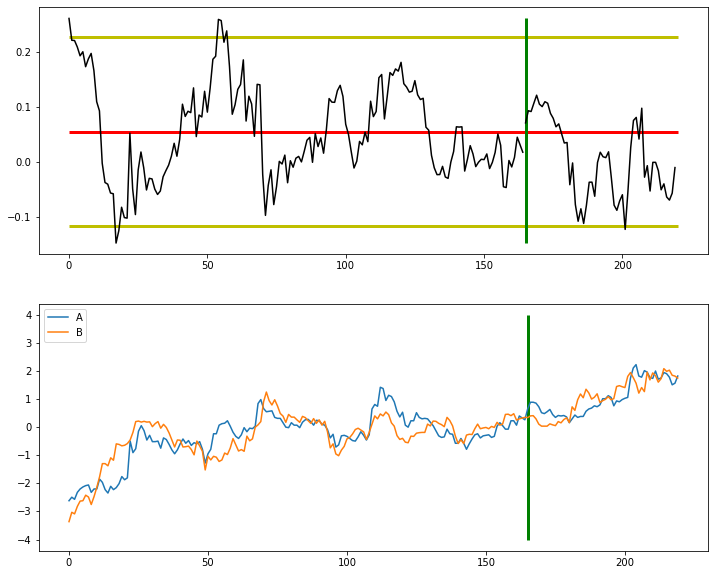

True

In [564]:
TradeVisual('023590','205100',1.2, '2020-04-01','2020-11-31',pr,2)

팅크웨어 & 현대모비스


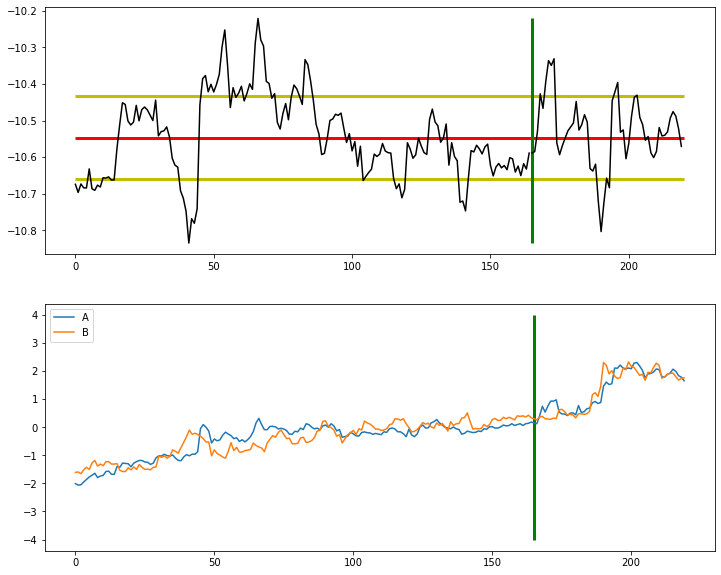

True

In [711]:
TradeVisual('084730','012330',1.6, '2020-04-01','2020-11-31',pr,1)

삼성전기 & 삼성물산


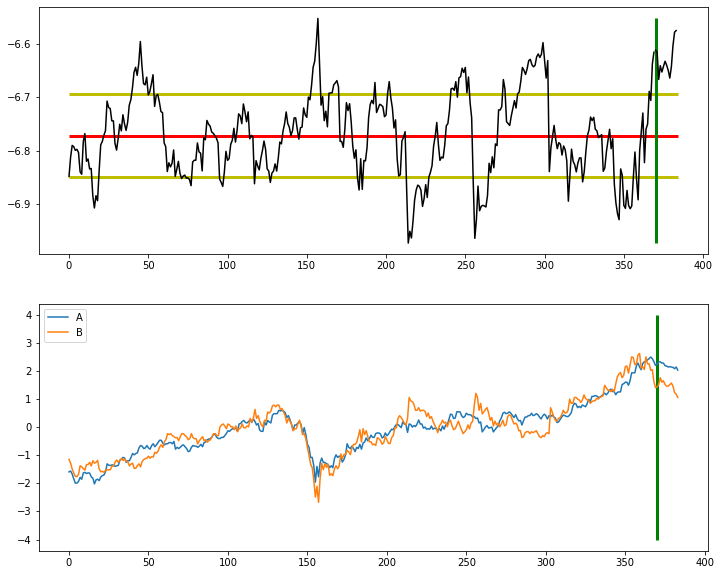

True

In [710]:
TradeVisual('009150','028260',1.6, '2019-08-01','2021-01-31',pr,1)

---

In [27]:
def PairTrading_v12(start, end, code_ls, cutoff=0.05, enter=1, pr_diff=20000):
    ldr = Loader()
    pr = ldr.GetPricelv2(start, end, code_ls)
    #pr = pr_df.copy()
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_lv2.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(5,21)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
#     for idx, row in cointeg_rst.iterrows():
#         print(row.A, row.B, row.cointeg)
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls

    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    #pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    A_price=[]
    B_price=[]
    pr_valid=[]
    for idx, row in pairs.iterrows():
        A = row.A
        B = row.B
        A_price.append(pr.loc[pr.index[-1],A])
        B_price.append(pr.loc[pr.index[-1],B])
        if abs(pr.loc[pr.index[-5:],A].mean() - row.cointeg * pr.loc[pr.index[-5:],B].mean()) <= pr_diff:
            pr_valid.append('Y')
        else :
            pr_valid.append('N')
        
    pairs['A_price'] = A_price
    pairs['B_price'] = B_price
    pairs['PR_VALID'] = pr_valid
    #pairs = pairs[pairs.index.isin(pr_valid)].reset_index(drop=True)
        
    return pairs

In [28]:
def TradeVisual_v2(A, B, eta, start, end, pr, enter=1):
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    try :
        print("{} & {}".format(ldr.FindNameByCode(A),ldr.FindNameByCode(B)))
    except :
        pass
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')

    ax1.hlines(spread.mean(),0,len(spread_full),colors='r',linewidth=3)
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='y',linewidth=3)
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='g',linewidth=3)

    ax2.plot(spread_full.reset_index().index, (aa_full - aa_full.mean())/aa_full.std(),label='A')
    ax2.plot(spread_full.reset_index().index, (bb_full - bb_full.mean())/bb_full.std(), label='B')
    ax2.vlines(len(spread),-4,4,colors='g',linewidth=3)
    ax2.legend(loc='upper left')
    plt.show()
    return True

In [133]:
hyundai = list(comp[comp.company.str.contains('현대')].code.values)
samsung = list(comp[comp.company.str.contains('삼성')].code.values) + ['005935']
lg = list(comp[comp.company.str.contains('LG')].code.values)
posco = list(comp[comp.company.str.contains('포스코')].code.values)

In [223]:
%%time
start = '2020-04-01'
end = '2021-02-26'
code_ls = ['005930','005935']
rst2 = PairTrading_v12(start, end, code_ls)

Initial number of companies : 2
Almost no change in price in this period -> removed : 0
Validation w.r.t Correlation : 1
Validation w.r.t Partial-Correlation by KOSPI : 1
Validation w.r.t CoIntegration : 1
Validation w.r.t Normality & Stationarity : 1
Adding Risk & Earnings & #Trade & #UpCut
Validation w.r.t Diff-Correlation : 1
Wall time: 553 ms


In [224]:
rst2

,A,B,corr,pcorr,cointeg,risk,A_earnings(%),A_trade#,A_maxterm,B_earnings(%),B_trade#,B_maxterm,dcorr,A_price,B_price,PR_VALID
0,005930,005935,0.994338,0.826852,0.9,0.009522,3.340016,4,83,3.000923,5,82,0.86412,82500.0,72800.0,Y


In [284]:
total_ls = []
for k in total_dict.keys():
    if k not in ['게임','제약','코로나','유전자','클라우드','증강현실','인터넷은행','5G','음성인식','쿠팡','자율주행차','전자결제','IT','4차산업']:
        total_ls += total_dict[k]
total_ls += lg
total_ls += samsung
total_ls += hyundai
total_ls += posco

In [285]:
total_ls = list(set(total_ls))

In [287]:
%%time
start = '2020-04-01'
end = '2021-02-26'
code_ls = total_ls
rst2 = PairTrading_v12(start, end, code_ls)

Initial number of companies : 467
Almost no change in price in this period -> removed : 18
Validation w.r.t Correlation : 77902
Validation w.r.t Partial-Correlation by KOSPI : 38297
Validation w.r.t CoIntegration : 6711
Validation w.r.t Normality & Stationarity : 808
Adding Risk & Earnings & #Trade & #UpCut
Validation w.r.t Diff-Correlation : 706
Wall time: 41min 31s


In [323]:
def VolumeCheck(pairs, end):
    tdays = ldr.GetTradingDays(end=end)
    end_idx = tdays.index(end)
    start = tdays[end_idx-30]
    pr_lv1 = ldr.GetPricelv1(start,end)
    median_df = pr_lv1.groupby(['CODE'])['volume'].mean()
    median_vol = median_df.median()
    over_median = list(median_df[lambda x : x >= median_vol].index)
    codeTOmedian = median_df.to_dict()
    
    meanVol=[]
    overVol=[]
    for idx, row in pairs.iterrows():
        A=row.A
        B=row.B
        if A in over_median and B in over_median :
            overVol.append('Y')
        else :
            overVol.append('N')
        meanVol.append((codeTOmedian[A]+codeTOmedian[B])/2)
    pairs['overVol'] = overVol
    pairs['meanVol'] = meanVol
    return pairs

In [325]:
qq = VolumeCheck(rst2[lambda x : x['PR_VALID']=='Y'],'2021-02-26')

In [328]:
qq2 = qq[lambda x : x['overVol']=='Y']

In [ ]:
for idx, row in qq[(qq['corr']>=0.5)&(qq.pcorr>=0.5)&(qq.dcorr>=0.5)].iterrows():
    try :
        print(row.A, row.B, ldr.FindNameByCode(row.A),ldr.FindNameByCode(row.B), round(row.cointeg,2), ldr.FindSectorByCode(row.A)+'|'+ldr.FindSectorByCode(row.B), row.overVol)
    except :
        print(row.A, row.B, row.cointeg)
        pass

In [385]:
rrr

,A,B,corr,pcorr,cointeg,risk,A_earnings(%),A_trade#,A_maxterm,B_earnings(%),B_trade#,B_maxterm,dcorr,A_price,B_price,PR_VALID
0,034220,066570,0.974448,0.667611,0.7,0.026434,8.739467,5,94,7.796678,5,75,0.465213,22600.0,146500.0,N


LG디스플레이 & LG전자


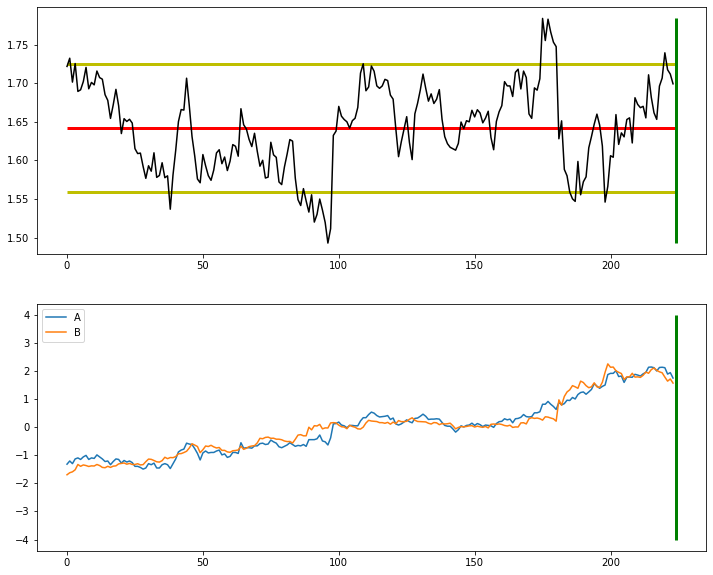

True

In [398]:
TradeVisual_v2('034220','066570',0.7, '2020-04-01','2021-02-26',pr,1.5)

In [586]:
def TradeVisual_v2(A, B, eta, start, end, enter=1):
    font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=15)
    color=iter(cm.rainbow(np.linspace(0,1,3)))
    ldr = Loader()
    pr = ldr.GetPricelv2(start,end,[A,B])
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    #plt.grid(True)
    try :
        A_name = ldr.FindNameByCode(A)
        B_name = ldr.FindNameByCode(B)
    except :
        if B == '005935':
            A_name = ldr.FindNameByCode(A)
            B_name = '삼성전자(우)'
        else:
            A_name = A
            B_name = B
    plt.title("PAIR TRADING : {} & {} with COINT-COEFF {}".format(A_name,B_name,etaa),fontproperties=fontprop)    
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')
    ax1.hlines(spread.mean(),0,len(spread_full),colors='blue',linewidth=3,linestyles='dashed')
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()+1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.hlines(spread.mean()-1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='purple',linewidth=2,linestyles='solid')
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    ax2.plot(spread_full.reset_index().index, pr[A],label=A)
    ax2.plot(spread_full.reset_index().index, pr[B],label=B)
    #ax2.plot(spread_full.reset_index().index, pr[A].rolling(5,1).mean(),label='{}_MA5'.format(A),color='skyblue')
    #ax2.plot(spread_full.reset_index().index, pr[B].rolling(5,1).mean(),label='{}_MA5'.format(B),color='gray')
    ax2.vlines(len(spread),-4,4,colors='purple',linewidth=2)
    ax2.legend(loc='upper left')
    #plt.grid(True)
    plt.show()
    return True

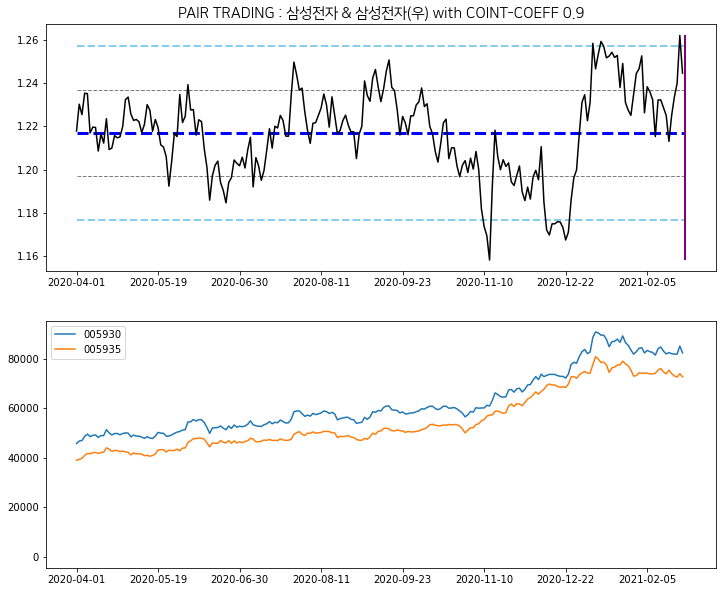

True

In [587]:
TradeVisual_v2('005930','005935',0.9, '2020-04-01','2021-02-31',2)

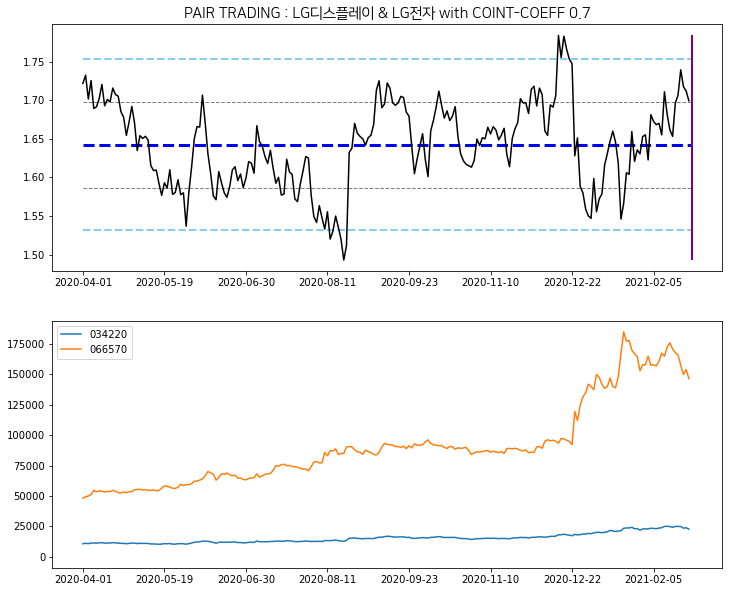

True

In [588]:
TradeVisual_v2('034220','066570',0.7, '2020-04-01','2021-02-31',2)

In [4]:
np.log(81900) - 0.9*np.log(72400)

1.2422888493047335

In [5]:
np.log(22400) - 0.7*np.log(145500)

1.6952642819275514